In [1]:
from collections import defaultdict
import math
import numpy as np
from numpy import ma
import datetime, time
from datetime import datetime
import netCDF4
from netCDF4 import Dataset, num2date
from scipy.interpolate import griddata

import RODFF
import RODFF.Mesh_maker as Mesh_maker
import RODFF.Functions as Functions
import RODFF.Calc_path as Calc_path

import matplotlib.pyplot as plt
plt.style.use('ggplot')
% matplotlib inline

import os
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# User defined values

In [2]:
nl = (1,1)
dx_min = 0.05
blend = 0.8


number_of_neighbor_layers = 2
vship = np.array([2,4,6])
WD_min = 1.5
Load_flow = Mesh_maker.flow_NOOS

name_textfile_flow = 'D:/Validatiecase TEXEL data (DCSMv6-ZUNOv4)/2018-05-08 060000.nc'
name_textfile_save = 'test'

In [3]:
start_time = time.time()

graph = Mesh_maker.Graph_flow_model(name_textfile_flow, 
                                    dx_min, 
                                    blend, 
                                    nl, 
                                    number_of_neighbor_layers, 
                                    vship, 
                                    Load_flow, 
                                    WD_min
                                   )

stop_time = time.time()
computation_time = stop_time - start_time
print("the computational time is:", round(computation_time,2), "sec")

4/4
the computational time is: 113.2 sec


In [4]:
RODFF.save_object(graph, name_textfile_save)

# Plots

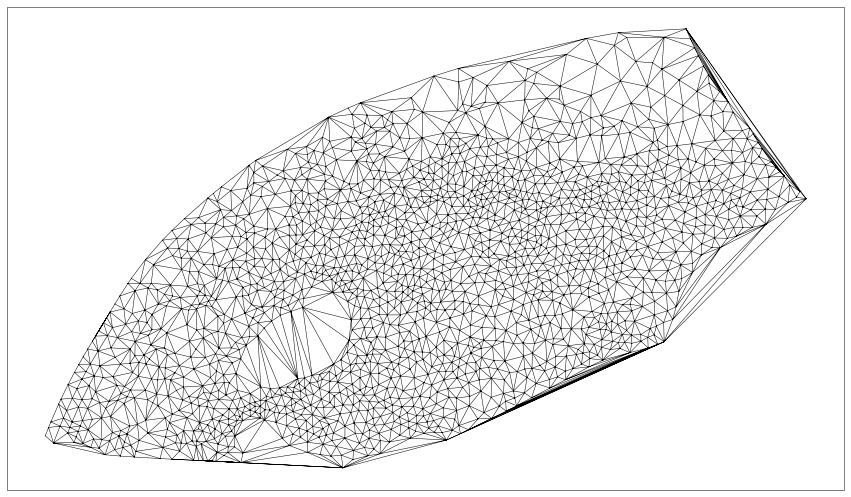

In [5]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.Mercator())

#cval = np.arange(0,1, 0.01)
#plt.contourf(x_r,y_r, LS_r, cval)
#cbar = plt.colorbar()

plt.triplot(graph.nodes[:,1], graph.nodes[:,0], graph.tria.simplices, linewidth = 0.5, color = 'k', label = 'Delauney edges')


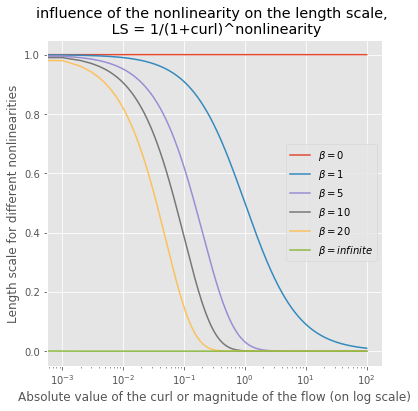

In [6]:
curl = np.arange(0,100,0.001)
def LS(nonlinearity):
    LS = 1/(1+curl)**nonlinearity
    return LS

fig = plt.figure()
fig.set_size_inches(6, 6)
plt.semilogx(curl, LS(0), label = r'$\beta =  0$')
plt.semilogx(curl, LS(1), label = r'$\beta =  1$')
plt.semilogx(curl, LS(5), label = r'$\beta =  5$')
plt.semilogx(curl, LS(10), label = r'$\beta =  10$')
plt.semilogx(curl, LS(20), label = r'$\beta =  20$')
plt.semilogx(curl, LS(np.inf), label = r'$\beta =  infinite$')

plt.title("influence of the nonlinearity on the length scale, \n LS = 1/(1+curl)^nonlinearity")
plt.xlabel("Absolute value of the curl or magnitude of the flow (on log scale)")
plt.ylabel("Length scale for different nonlinearities")

plt.legend(loc = 'best')
#plt.savefig("Influence_of_nonlinearity", dpi = 200)
plt.show()

In [7]:
x_r = np.arange(4.5,5.5, 0.001)
y_r = np.arange(53,54, 0.01)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = griddata((graph.nodes[:,1], graph.nodes[:,0]), graph.WD[:,1], (x_r, y_r), method= 'linear')

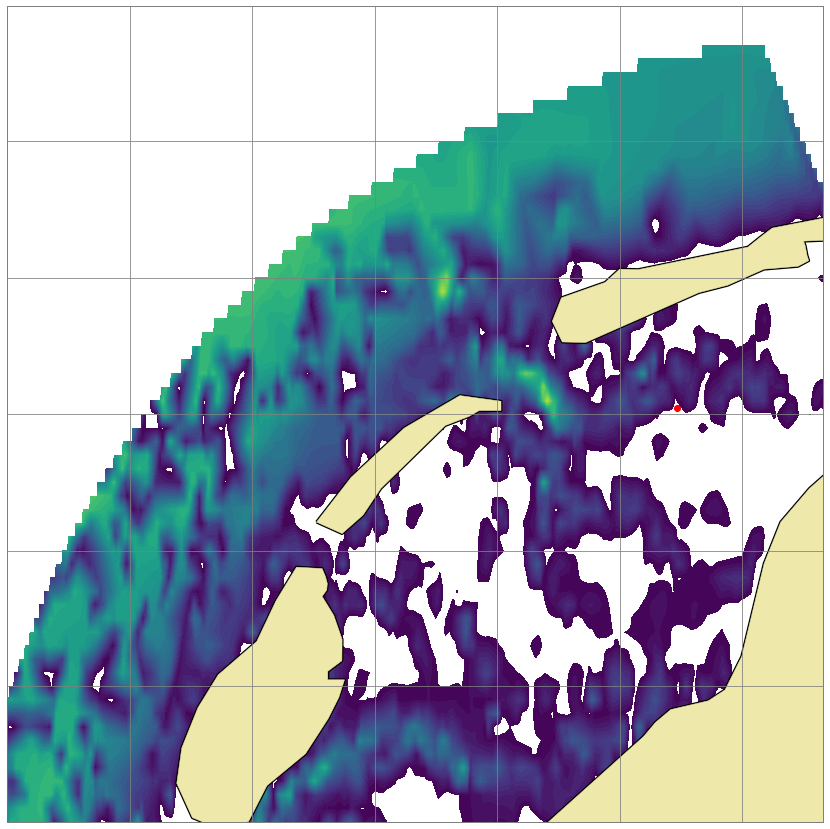

42.7551166528639


In [8]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.Mercator())

cval = np.arange(2.5,40,1)
plt.contourf(x_r,y_r,WD_r, cval, transform=ccrs.PlateCarree())
#cbar = plt.colorbar()

ax.coastlines(resolution='10m', color='black', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))

plt.plot(graph.nodes[550][1],graph.nodes[550][0], 'ro', transform=ccrs.PlateCarree())
plt.show()


print(len(graph.nodes)**0.5)